In [49]:
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta
import matplotlib.pyplot as plt
from scipy import stats,optimize
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_squared_error
import math
from noaa_sdk import noaa


In [52]:
for observation in observations:
    print(observation)
    break

{'@id': 'https://api.weather.gov/stations/KJFK/observations/2017-06-11T21:51:00+00:00', '@type': 'wx:ObservationStation', 'elevation': {'value': 7, 'unitCode': 'unit:m'}, 'station': 'https://api.weather.gov/stations/KJFK', 'timestamp': '2017-06-11T21:51:00+00:00', 'rawMessage': 'KJFK 112151Z 19014KT 10SM BKN250 26/19 A3000 RMK AO2 SLP159 T02560194', 'textDescription': 'Mostly Cloudy', 'icon': 'https://api.weather.gov/icons/land/day/bkn?size=medium', 'presentWeather': [], 'temperature': {'value': None, 'unitCode': 'unit:degC', 'qualityControl': 'qc:Z'}, 'dewpoint': {'value': 19.399987792968773, 'unitCode': 'unit:degC', 'qualityControl': 'qc:V'}, 'windDirection': {'value': 190, 'unitCode': 'unit:degree_(angle)', 'qualityControl': 'qc:V'}, 'windSpeed': {'value': 7.199999809265137, 'unitCode': 'unit:m_s-1', 'qualityControl': 'qc:V'}, 'windGust': {'value': None, 'unitCode': 'unit:m_s-1', 'qualityControl': 'qc:Z'}, 'barometricPressure': {'value': 101590, 'unitCode': 'unit:Pa', 'qualityContro

In [12]:
raw_spiro = pd.read_csv('raw_spiro.csv',parse_dates=['Date'])

In [13]:
import requests
import json
#station GHCND:USW00014732
#get yours https://www.ncdc.noaa.gov/cdo-web/token
NOAA_TOKEN = %env NOAA_TOKEN

In [14]:
#WBAN:14732 not available via api
#r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/datasets?stationid=WBAN:14732',
#headers={'token':Token})
#d = json.loads(r.text)
#returns empty - still available at
# noaa_request('datasets','stationid=WBAN:94728') also errors 
#https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:14732/detail
#change hour to hours since sleep?

In [39]:
r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=WBAN:14732'
                 + '&startdate=' + raw_spiro['Date'].min().strftime('%Y-%m-%d')
                 + '&enddate='+raw_spiro['Date'].max().strftime('%Y-%m-%d'),
                 headers={'token':NOAA_TOKEN})
r
d = json.loads(r.text)
d

{}

In [48]:
weather_factor_dict = noaa_request('datatypes','')
weather_factor_dict

[{'datacoverage': 0.95,
  'id': 'ALL',
  'maxdate': '2020-03-31',
  'mindate': '1991-06-05',
  'name': 'Base Data'},
 {'datacoverage': 1,
  'id': 'AWND',
  'maxdate': '2020-03-30',
  'mindate': '1982-01-01',
  'name': 'Average wind speed'},
 {'datacoverage': 0.95,
  'id': 'DAA',
  'maxdate': '2020-03-10',
  'mindate': '2011-03-08',
  'name': 'Digital Accumulation Array(One Hour Precipitation total (256 levels) with Dual Pol. algorithm)'},
 {'datacoverage': 1,
  'id': 'DAPR',
  'maxdate': '2020-03-31',
  'mindate': '1832-05-11',
  'name': 'Number of days included in the multiday precipitation total (MDPR)'},
 {'datacoverage': 1,
  'id': 'DATN',
  'maxdate': '2020-03-22',
  'mindate': '1863-05-04',
  'name': 'Number of days included in the multiday minimum temperature (MDTN)'},
 {'datacoverage': 1,
  'id': 'DATX',
  'maxdate': '2020-03-21',
  'mindate': '1863-05-04',
  'name': 'Number of days included in the multiday maximum temperature (MDTX)'},
 {'datacoverage': 0.95,
  'id': 'DHR',
  

In [45]:
noaa_request('datacategories','stationid='+'WBAN:14732')

KeyError: 'metadata'

In [15]:
#requests must be less than a year in length
def noaa_request(endpoint,params,offset=1,enddate=raw_spiro['Date'].max().strftime('%Y-%m-%d')):
    r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/' + endpoint +'?'
                 + params
                 + '&startdate=' + raw_spiro['Date'].min().strftime('%Y-%m-%d')
                 + '&enddate='+enddate
                 + '&limit=1000'
                 + '&offset=' + str(offset)
                 ,headers={'token':NOAA_TOKEN})
    data = json.loads(r.text)
    if (data['metadata']['resultset']['count'] >= 1000):
        return noaa_request(endpoint,params,offset+1000) + data['results']
    return data['results']

In [42]:
#we need a station id, you can skip this and get it by going to
#https://www.ncdc.noaa.gov/cdo-web/datatools/findstation and copy the ID of a station
#it must begin with GHCND

#if this prints more than one result - choose the one closest to you

locationid = 'ZIP:11371' #change to your location
stations = noaa_request('stations','locationid='+locationid)
print(stations[0]['name'], stations[0]['id'])
print(stations)
station_id = stations[0]['id']

LAGUARDIA AIRPORT, NY US GHCND:USW00014732
[{'elevation': 3.4, 'mindate': '1939-10-07', 'maxdate': '2020-03-30', 'latitude': 40.77944, 'name': 'LAGUARDIA AIRPORT, NY US', 'datacoverage': 1, 'id': 'GHCND:USW00014732', 'elevationUnit': 'METERS', 'longitude': -73.88035}, {'elevation': 45.4, 'mindate': '1995-04-26', 'maxdate': '2020-03-31', 'latitude': 39.94694, 'name': 'PHILADELPHIA, NJ US', 'datacoverage': 0.95, 'id': 'NEXRAD:KDIX', 'elevationUnit': 'METERS', 'longitude': -74.41111}, {'elevation': 556.6, 'mindate': '1995-05-09', 'maxdate': '2020-03-31', 'latitude': 42.58639, 'name': 'ALBANY, NY US', 'datacoverage': 0.95, 'id': 'NEXRAD:KENX', 'elevationUnit': 'METERS', 'longitude': -74.06444}, {'elevation': 25.9, 'mindate': '1995-04-27', 'maxdate': '2020-03-31', 'latitude': 40.86556, 'name': 'NEW YORK CITY, NY US', 'datacoverage': 0.95, 'id': 'NEXRAD:KOKX', 'elevationUnit': 'METERS', 'longitude': -72.86444}, {'elevation': 3.4, 'mindate': '1948-07-01', 'maxdate': '2020-03-30', 'latitude': 

In [50]:
n = noaa.NOAA()
observations = n.get_observations('11432','US',start=raw_spiro['Date'].min().strftime('%Y-%m-%d'),
                                  end=raw_spiro['Date'].max().strftime('%Y-%m-%d'))


In [54]:
a = []
for observation in observations:
    a.append(observation)
a[0]

{'@id': 'https://api.weather.gov/stations/KJFK/observations/2017-06-10T11:51:00+00:00',
 '@type': 'wx:ObservationStation',
 'barometricPressure': {'qualityControl': 'qc:V',
  'unitCode': 'unit:Pa',
  'value': 101560},
 'cloudLayers': [{'amount': 'FEW',
   'base': {'unitCode': 'unit:m', 'value': 3350}},
  {'amount': 'SCT', 'base': {'unitCode': 'unit:m', 'value': 7620}}],
 'dewpoint': {'qualityControl': 'qc:V',
  'unitCode': 'unit:degC',
  'value': 13.899987792968773},
 'elevation': {'unitCode': 'unit:m', 'value': 7},
 'heatIndex': {'qualityControl': 'qc:V',
  'unitCode': 'unit:degC',
  'value': 21.523292322514635},
 'icon': 'https://api.weather.gov/icons/land/day/sct?size=medium',
 'maxTemperatureLast24Hours': {'qualityControl': None,
  'unitCode': 'unit:degC',
  'value': None},
 'minTemperatureLast24Hours': {'qualityControl': None,
  'unitCode': 'unit:degC',
  'value': None},
 'precipitationLast3Hours': {'qualityControl': 'qc:Z',
  'unitCode': 'unit:m',
  'value': None},
 'precipitatio

In [23]:
weather_factor_dict = noaa_request('datatypes','datasetid=GHCND')
station_factors = noaa_request('data','datasetid=GHCND&stationid='+station_id)
datatypes={}
for x in station_factors:
    for y in weather_factor_dict:
        if (y['id'] == x['datatype']):
            datatypes[x['datatype']] = y['name']

In [18]:
weather_factor_dict

[{'datacoverage': 1,
  'id': 'AWND',
  'maxdate': '2020-03-30',
  'mindate': '1982-01-01',
  'name': 'Average wind speed'},
 {'datacoverage': 1,
  'id': 'DAPR',
  'maxdate': '2020-03-31',
  'mindate': '1832-05-11',
  'name': 'Number of days included in the multiday precipitation total (MDPR)'},
 {'datacoverage': 1,
  'id': 'DATN',
  'maxdate': '2020-03-22',
  'mindate': '1863-05-04',
  'name': 'Number of days included in the multiday minimum temperature (MDTN)'},
 {'datacoverage': 1,
  'id': 'DATX',
  'maxdate': '2020-03-21',
  'mindate': '1863-05-04',
  'name': 'Number of days included in the multiday maximum temperature (MDTX)'},
 {'datacoverage': 1,
  'id': 'DWPR',
  'maxdate': '2020-03-22',
  'mindate': '1832-05-11',
  'name': 'Number of days with non-zero precipitation included in multiday precipitation total (MDPR)'},
 {'datacoverage': 1,
  'id': 'EVAP',
  'maxdate': '2020-02-29',
  'mindate': '1893-01-09',
  'name': 'Evaporation of water from evaporation pan'},
 {'datacoverage':

In [19]:
def get_weather_factor(factor):
    factor_results = noaa_request('data','datasetid=GHCND&datatypeid='+factor+'&stationid='+station_id)
    rangedata = pd.date_range(raw_spiro['Date'].min(),raw_spiro['Date'].max())
    dateVals = pd.Series(index=rangedata)
    for x in factor_results:
        dateVals[pd.to_datetime(x['date'][:10],format= '%Y-%m-%d' )] = x['value']
    return dateVals

In [22]:
station_id = 'GHCND:USW00094728'


In [24]:
datatypes

{'AWND': 'Average wind speed',
 'PGTM': 'Peak gust time',
 'PRCP': 'Precipitation',
 'SNOW': 'Snowfall',
 'SNWD': 'Snow depth',
 'TMAX': 'Maximum temperature',
 'TMIN': 'Minimum temperature',
 'WDF2': 'Direction of fastest 2-minute wind',
 'WDF5': 'Direction of fastest 5-second wind',
 'WSF2': 'Fastest 2-minute wind speed',
 'WSF5': 'Fastest 5-second wind speed',
 'WT01': 'Fog, ice fog, or freezing fog (may include heavy fog)',
 'WT08': 'Smoke or haze '}

In [258]:
#choose factors to use
datatypes

{'AWND': 'Average wind speed',
 'PGTM': 'Peak gust time',
 'PRCP': 'Precipitation',
 'SNOW': 'Snowfall',
 'SNWD': 'Snow depth',
 'TAVG': 'Average Temperature.',
 'TMAX': 'Maximum temperature',
 'TMIN': 'Minimum temperature',
 'WDF2': 'Direction of fastest 2-minute wind',
 'WDF5': 'Direction of fastest 5-second wind',
 'WSF2': 'Fastest 2-minute wind speed',
 'WSF5': 'Fastest 5-second wind speed',
 'WT01': 'Fog, ice fog, or freezing fog (may include heavy fog)',
 'WT08': 'Smoke or haze '}

In [259]:
raw_weather=pd.DataFrame(index=pd.date_range(raw_spiro['Date'].min(),raw_spiro['Date'].max()))
raw_weather['PRCP'] = getWeatherFactor('PRCP').fillna(0) #precipitation
raw_weather['AWND'] = getWeatherFactor('AWND').fillna(0)/10 #average wind speed - pretty sure I need to divide by 10
raw_weather['WT08'] = getWeatherFactor('WT08').fillna(0) 
raw_weather['TAVG'] = getWeatherFactor('TAVG')/10
raw_weather = raw_weather.dropna()
raw_weather['unixDate']= raw_weather.index.astype(np.int64)// 10**9
raw_weather['unixDate'] = raw_weather['unixDate']/86400
raw_weather.index =raw_weather['unixDate']

In [260]:
raw_spiro.index = raw_spiro['unixDate']
raw_spiro = raw_spiro.drop('unixDate')
raw_weather = raw_weather.drop('unixDate',axis=1)
temp_spiro = raw_weather.join(raw_spiro,how='inner').dropna()
temp_spiro.head()


,PRCP,AWND,WT08,TAVG,Date,Time,PEF(l/min),FEV1(l),unixDate,unixTime,Hour
unixDate,,,,,,,,,,,
18312.0,0.0,6.0,0.0,0.7,2020-02-20,1900-01-01 10:12:00,219,1.72,18312.0,36720.0,10.200000
18312.0,0.0,6.0,0.0,0.7,2020-02-20,1900-01-01 11:45:00,253,1.78,18312.0,42300.0,11.750000
18313.0,0.0,4.5,0.0,-2.1,2020-02-21,1900-01-01 03:31:00,388,2.54,18313.0,12660.0,3.516667
18313.0,0.0,4.5,0.0,-2.1,2020-02-21,1900-01-01 00:08:00,415,2.89,18313.0,480.0,0.133333
18314.0,0.0,4.5,0.0,3.4,2020-02-22,1900-01-01 19:32:00,476,2.78,18314.0,70320.0,19.533333


In [261]:
Y = temp_spiro['PEF(l/min)']
X = temp_spiro[['TAVG','AWND','PRCP','WT08','unixDate','Hour']]

mod = sm.OLS(Y,X)
fit = mod.fit()
summary = fit.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             PEF(l/min)   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              427.8
Date:                Thu, 02 Apr 2020   Prob (F-statistic):                    3.16e-75
Time:                        16:57:52   Log-Likelihood:                         -689.38
No. Observations:                 119   AIC:                                      1391.
Df Residuals:                     113   BIC:                                      1407.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TAVG           1.2560      2.040      0.616      0.539      -2.786       5.298
AWND          12.8920      5.782      2.230      0.028       1.437      24.347
PRCP          -0.6230      0.447     -1.393      0.166      -1.509       0.263
WT08          17.8211     31.885      0.559      0.577     -45.350      80.992
unixDate       0.0174      0.002      9.034      0.000       0.014       0.021
Hour          -1.5166      1.115     -1.360      0.176      -3.725       0.692
==============================================================================
Omnibus:                        1.797   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.407   Jarque-Bera (JB):                1.397
Skew:                           0.042   Prob(JB):                        0.497
Kurtosis:                       2.476   Cond. No.                     7.83e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

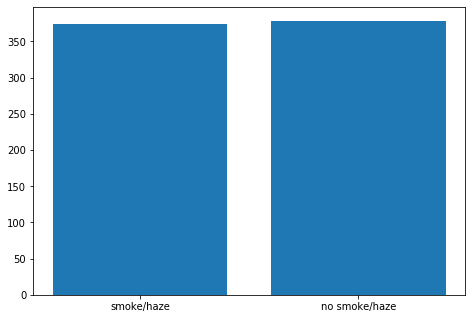

In [283]:
#LinRegPlot(temp_spiro['WT08'],temp_spiro['PEF(l/min)'])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
smoke = ['smoke/haze','no smoke/haze']
values = [temp_spiro.loc[temp_spiro['WT08']==1]['PEF(l/min)'].mean(),
            temp_spiro.loc[temp_spiro['WT08']==0]['PEF(l/min)'].mean()]
ax.bar(smoke,values)
plt.show()

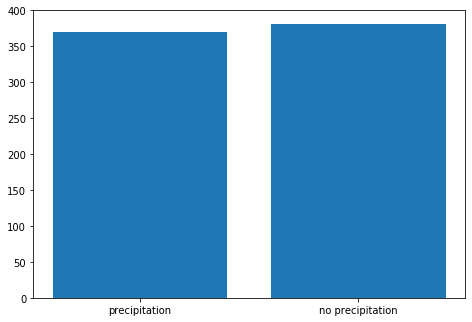

In [282]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
smoke = ['precipitation','no precipitation']
values = [temp_spiro.loc[temp_spiro['PRCP']>0]['PEF(l/min)'].mean(),
            temp_spiro.loc[temp_spiro['PRCP']==0]['PEF(l/min)'].mean()]
ax.bar(smoke,values)
plt.show()

In [218]:
#find what sorts of reports are available for what area
#https://docs.airnowapi.org/Data/query
#http://www.airnowapi.org/aq/data/?startDate=2020-02-21T13&endDate=2020-03-26T14&parameters=OZONE,PM25,PM10,CO,NO2,SO2&BBOX=-73.870000,40.696253,-73.792409,40.762596&dataType=B&format=text/csv&verbose=1&nowcastonly=0&includerawconcentrations=1&API_KEY=
#to-do learn api format https://docs.airnowapi.org/Data/docs
#get other pollution concentrations
colnames=["Latitude","Longitude","UTC","Parameter","Concentration","Unit","Raw Concentration","AQI","Category",
    "Site Name","Site Agency","AQS ID","Full AQS ID"] 
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%dT%H:%M')

#df = pd.read_csv(infile, parse_dates=['datetime'], date_parser=dateparse)

AQI = pd.read_csv('./Output.csv',parse_dates=['UTC'], date_parser=dateparse,names=colnames, header=None)
AQI = AQI[["UTC","Parameter","Concentration","AQI","Site Name"]]
#we have hourly results but we won't use all that data yet
AQI['UTC']=AQI['UTC'].apply(lambda x: datetime(year=x.year, month=x.month, day=x.day))
AQI['unixDate']= AQI['UTC'].astype(np.int64)// 10**9
AQI['unixDate'] = AQI['unixDate']/86400

AQITotal = AQI[['unixDate','AQI']]
AQITotal.index = AQITotal['unixDate']
AQITotal = AQITotal.groupby(AQITotal['unixDate']).mean()
#AQITotal = AQITotal.drop(['unixDate'], axis=1)
AQI = AQI.drop(['AQI'], axis=1)


In [219]:
#ozone=ozone.rename(columns={"Concentration": "ozone"})
AQITotal.head()

,AQI
unixDate,
18313.0,22.272727
18314.0,27.638889
18315.0,34.902778
18316.0,40.250000
18317.0,31.708333


In [222]:
temp_spiro.head()

,PRCP,WT08,TAVG,Date,Time,PEF(l/min),FEV1(l),unixDate,unixTime
unixDate,,,,,,,,,
18314.0,0.0,0.0,38.0,2020/2/22,03:31:00,388,2.54,18314.0,12660.0
18314.0,0.0,0.0,38.0,2020/2/22,00:08:00,415,2.89,18314.0,480.0
18315.0,0.0,0.0,47.0,2020/2/23,19:32:00,476,2.78,18315.0,70320.0
18316.0,0.0,0.0,49.0,2020/2/24,05:13:00,294,1.62,18316.0,18780.0
18316.0,0.0,0.0,49.0,2020/2/24,15:37:00,384,2.49,18316.0,56220.0


In [220]:
def formatPollutionTables(pollutant,site=""):
    table = AQI.copy()
    table = table.where(table['Parameter']==pollutant)
    table = table.rename(columns={"Concentration":pollutant+site})
    if (pollutant == 'PM2.5'):
        table = table.where(table["Site Name"]==site).dropna()
    return table.groupby(table['unixDate']).mean()

ozone = formatPollutionTables("OZONE")
PM25 = formatPollutionTables("PM2.5","Queens")
PM25Road = formatPollutionTables("PM2.5","Queens Near-road")

In [225]:
raw_spiro.index=raw_spiro['unixDate']
temp_spiro.index=temp_spiro['unixDate']

all_data = ozone.join(PM25).join(PM25Road).join(AQITotal).join(temp_spiro).dropna()
all_data = all_data.drop(['Date','Time'],axis=1)
all_data.head()

,OZONE,PM2.5Queens,PM2.5Queens Near-road,AQI,PRCP,WT08,TAVG,PEF(l/min),FEV1(l),unixDate,unixTime
unixDate,,,,,,,,,,,
18314.0,22.291667,7.404167,7.479167,27.638889,0.0,0.0,38.0,388.0,2.54,18314.0,12660.0
18314.0,22.291667,7.404167,7.479167,27.638889,0.0,0.0,38.0,415.0,2.89,18314.0,480.0
18315.0,19.000000,10.737500,10.116667,34.902778,0.0,0.0,47.0,476.0,2.78,18315.0,70320.0
18316.0,15.666667,13.283333,13.137500,40.250000,0.0,0.0,49.0,294.0,1.62,18316.0,18780.0
18316.0,15.666667,13.283333,13.137500,40.250000,0.0,0.0,49.0,384.0,2.49,18316.0,56220.0


In [178]:
pollution_breath = PM25Road.join(raw_spiro,how='outer').dropna()
pollution_breath.head()

,PM2.5,Date,Time,PEF(l/min),FEV1(l),unixDate,unixTime
unixDate,,,,,,,
18314.0,7.479167,2020/2/22,03:31:00,388.0,2.54,18314.0,12660.0
18314.0,7.479167,2020/2/22,00:08:00,415.0,2.89,18314.0,480.0
18315.0,10.116667,2020/2/23,19:32:00,476.0,2.78,18315.0,70320.0
18316.0,13.137500,2020/2/24,05:13:00,294.0,1.62,18316.0,18780.0
18316.0,13.137500,2020/2/24,15:37:00,384.0,2.49,18316.0,56220.0


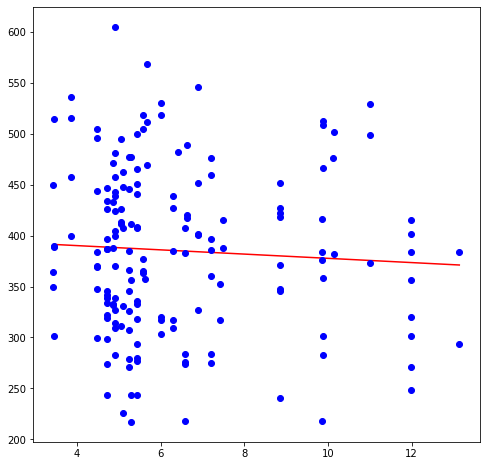

R-squared is 0.0
Beta 1 is -2.08


In [181]:
linReg(pollution_breath['PM2.5'],pollution_breath['PEF(l/min)'])


In [185]:
glm = generalized_linear_model.GLM(pollution_breath['PEF(l/min)'],pollution_breath['PM2.5'],  
                                   family=sm.families.Gaussian())

result = glm.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             PEF(l/min)   No. Observations:                  169
Model:                            GLM   Df Residuals:                      168
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                          24536.
Method:                          IRLS   Log-Likelihood:                -1093.4
Date:                Fri, 27 Mar 2020   Deviance:                   4.1220e+06
Time:                        12:49:52   Pearson chi2:                 4.12e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PM2.5         53.1495      1.773     29.973      0.000      49.674      56.625
==============================================================================
"""

In [186]:
from  statsmodels.genmod import generalized_linear_model
glm = generalized_linear_model.GLM(temp_spiro['PEF(l/min)'], temp_spiro['WT08'], family=sm.families.Binomial())

result = glm.fit()
result.summary()
#evidence of WT-08 causing breath to be worse

/home/robin/.local/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/home/robin/.local/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/home/robin/.local/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: invalid value encountered in add
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/home/robin/.local/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:943: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             PEF(l/min)   No. Observations:                  141
Model:                            GLM   Df Residuals:                      140
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 27 Mar 2020   Deviance:                   4.5547e+06
Time:                        12:50:27   Pearson chi2:                 8.70e+21
No. Iterations:                     2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WT08        2.392e+18   1.73e+07   1.38e+11      0.000    2.39e+18    2.39e+18
==============================================================================
"""

In [234]:
a = list(all_data.columns)
a.remove('PEF(l/min)','FEV1(l)')
a

TypeError: remove() takes exactly one argument (2 given)

In [241]:
Y = all_data[['PEF(l/min)']]
x_col = list(all_data.columns)
x_col.remove('PEF(l/min)')
x_col.remove('FEV1(l)')
x_col
X = all_data[x_col]
X = sm.add_constant(X)

mod = sm.OLS(Y,X)
fii = mod.fit()
p_values = fii.summary()
p_values

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PEF(l/min)   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.6812
Date:                Fri, 27 Mar 2020   Prob (F-statistic):              0.725
Time:                        13:42:04   Log-Likelihood:                -812.60
No. Observations:                 141   AIC:                             1645.
Df Residuals:                     131   BIC:                             1675.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   4.34e+04   2.72e+04      1.594      0.113   -1.04e+04    9.72e+04
OZONE                   -10.3307     11.387     -0.907      0.366     -32.857      12.195
PM2.5Queens             -53.5837     54.802     -0.978      0.330    -161.995      54.827
PM2.5Queens Near-road   -34.6435     50.708     -0.683      0.496    -134.956      65.669
AQI                      31.3304     38.127      0.822      0.413     -44.094     106.755
PRCP                     56.2902     35.851      1.570      0.119     -14.633     127.213
WT08                    -45.9713     25.911     -1.774      0.078     -97.229       5.286
TAVG                      2.1403      1.515      1.413      0.160      -0.857       5.137
unixDate                 -2.3520      1.487     -1.582      0.116      -5.293       0.589
unixTime              -3.454e-05      0.000     -0.129      0.898      -0.001       0.000
==============================================================================
Omnibus:                        1.311   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.519   Jarque-Bera (JB):                1.299
Skew:                           0.133   Prob(JB):                        0.522
Kurtosis:                       2.613   Cond. No.                     2.14e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [190]:
pollution_breath.head()

,PM2.5,Date,Time,PEF(l/min),FEV1(l),unixDate,unixTime
unixDate,,,,,,,
18314.0,7.479167,2020/2/22,03:31:00,388.0,2.54,18314.0,12660.0
18314.0,7.479167,2020/2/22,00:08:00,415.0,2.89,18314.0,480.0
18315.0,10.116667,2020/2/23,19:32:00,476.0,2.78,18315.0,70320.0
18316.0,13.137500,2020/2/24,05:13:00,294.0,1.62,18316.0,18780.0
18316.0,13.137500,2020/2/24,15:37:00,384.0,2.49,18316.0,56220.0


In [194]:
Y = pollution_breath['PEF(l/min)']
X = pollution_breath['PM2.5']
X = sm.add_constant(X)

mod = sm.OLS(Y,X)
fii = mod.fit()
p_values = fii.summary()
p_values

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PEF(l/min)   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5848
Date:                Fri, 27 Mar 2020   Prob (F-statistic):              0.446
Time:                        13:19:02   Log-Likelihood:                -981.12
No. Observations:                 169   AIC:                             1966.
Df Residuals:                     167   BIC:                             1973.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        398.4753     18.503     21.535      0.000     361.944     435.006
PM2.5         -2.0825      2.723     -0.765      0.446      -7.459       3.294
==============================================================================
Omnibus:                        3.957   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.138   Jarque-Bera (JB):                2.611
Skew:                           0.110   Prob(JB):                        0.271
Kurtosis:                       2.432   Cond. No.                         20.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
#multi-linear regression - investigate further
ols = linear_model.LinearRegression()
X = temp_spiro[['unixDate', 'FEV1(l)', 'unixTime','PRCP','TAVG','WT08']]  # input varialbe
Y = temp_spiro['PEF(l/min)']  # output variable
ols.fit(X, Y)
print("Intercept: %f" %ols.intercept_)
print("Coefficients: %s" %str(ols.coef_))
print("R^2: %f" %(ols.score(X, Y)))
ols.get_params()

Intercept: -14061.406504
Coefficients: [ 7.68021310e-01  1.46647246e+02 -1.39668447e-04 -2.00085216e+01
  2.94322816e-01 -3.86657168e+00]
R^2: 0.828610


{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [32]:
mod = sm.OLS(Y,X)
fii = mod.fit()
p_values = fii.summary2()
p_values
#no strong correlation other than FEV

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.992    
Dependent Variable:     PEF(l/min)       AIC:                         1322.4903
Date:                   2020-03-25 17:11 BIC:                         1339.8324
No. Observations:       133              Log-Likelihood:              -655.25  
Df Model:               6                F-statistic:                 2853.    
Df Residuals:           127              Prob (F-statistic):          7.65e-133
R-squared (uncentered): 0.993            Scale:                       1166.3   
-----------------------------------------------------------------------------------
              Coef.       Std.Err.        t        P>|t|       [0.025       0.975] 
-----------------------------------------------------------------------------------
unixDate       0.0004       0.0015      0.2523     0.8012      -0.0026       0.0034
FEV1(l)      144.8441       6.1181     23.6747     0.0000     132.7375     156.9507
unixTime      -0.0001       0.0001     -0.9917     0.3232      -0.0003       0.0001
PRCP         -13.2507      13.5745     -0.9761     0.3308     -40.1121      13.6108
TAVG           0.5633       0.4806      1.1721     0.2433      -0.3877       1.5142
WT08         -11.1143       9.7108     -1.1445     0.2546     -30.3302       8.1016
-------------------------------------------------------------------------------
Omnibus:                   52.561           Durbin-Watson:              2.057  
Prob(Omnibus):             0.000            Jarque-Bera (JB):           313.697
Skew:                      1.197            Prob(JB):                   0.000  
Kurtosis:                  10.133           Condition No.:              255361 
===============================================================================
* The condition number is large (3e+05). This might indicate             strong
multicollinearity or other numerical problems.
"""

In [33]:
#same analysis - different weather source
X = newtemp_spiro[['FEV1(l)','DailyAverageDryBulbTemperature','DailyAverageStationPressure','DailyPrecipitation','unixDate','unixTime']]
Y = newtemp_spiro['PEF(l/min)']  # output variable
ols.fit(X, Y)
print("Intercept: %f" %ols.intercept_)
print("Coefficients: %s" %str(ols.coef_))
print("R^2: %f" %(ols.score(X, Y)))
ols.get_params()
#very similar to above

Intercept: -16633.004984
Coefficients: [ 1.47431994e+02  1.85513748e-01 -1.69166911e+00 -2.31983848e+01
  9.11260269e-01 -1.39833625e-04]
R^2: 0.828448


{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}